# Understanding redrock output

This tutorial describes how to combine the zbest fit coefficients with the
redrock templates to see how the best fit template compares to the actual data.

See https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC to configure Jupyter at NERSC to be able to run this
tutorial using jupyter.nersc.gov and the fuji data in `/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80618/20210328/`. This notebook runs on kernel 22.2. 

If running locally, see https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop for installing code and download the the fuji reference run data set from NERSC at `/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80618/20210328/`.

The bottom of this tutorial lists the code versions used while testing this.

Stephen Bailey<br/>
December 2020 (last mofified in July 2022)

## Basic setup

In [1]:
import os
from astropy.table import Table
import numpy as np
import desispec.io
# import redrock.io
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Add the tutorials directory to the python search path so that we can import desitutorials

In [2]:
sys.path.append(os.path.abspath(os.getcwd()+'/../py/'))
import desitutorials

For convenience, move into the directory that contains the reference run data and set some environment variables so that desispec can find the files.  If you are running locally (*e.g.* on your laptop instead of at jupyter.nersc.gov, replace these with wherever you installed the reference run data.

In [3]:
os.chdir('/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80618/20210328/')
# os.environ['DESI_SPECTRO_REDUX'] = os.path.join(os.getcwd(), 'spectro', 'redux')
# os.environ['SPECPROD'] = 'mini'

## Read in some spectra and the matching zbest file

In [4]:
# specfile = desispec.io.findfile('spectra', groupname='5299', nside=64)
# zbestfile = desispec.io.findfile('zbest', groupname='5299', nside=64)
zbest = Table.read('redrock-0-80618-thru20210328.fits', hdu=1).filled('')
spectra = desispec.io.read_spectra('coadd-0-80618-thru20210328.fits')

INFO:spectra.py:285:read_spectra: iotime 0.559 sec to read coadd-0-80618-thru20210328.fits at 2022-07-18T00:35:24.704357


Also read the fibermap and trim to a unique set that row-matches the zbest file;
we'll use this later to pick targets targeted as ELGs.

In [5]:
fm = Table.read('redrock-0-80618-thru20210328.fits', hdu='FIBERMAP')
ii=sorted(np.unique(fm['TARGETID'], return_index=True)[1])
assert np.all(fm['TARGETID'] == zbest['TARGETID'])
fm = fm[ii]

What did we get?

In [6]:
zbest['SPECTYPE', 'Z'][0:5]

SPECTYPE,Z
bytes6,float64
GALAXY,0.3149693869731157
GALAXY,0.2744179435430135
GALAXY,1.015669441003412
GALAXY,0.17662953544131388
GALAXY,0.17868639941777054


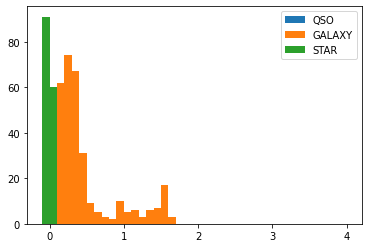

In [7]:
for spectype in set(zbest['SPECTYPE']):
    ii = (zbest['SPECTYPE'] == spectype)
    hist(zbest['Z'][ii], 41, (-0.1,4), label=spectype.strip())
legend()

Note that redrock does not distinguish between ELGs and LRGs: both are just `spectype=='GALAXY'`.

## Compare redrock templates to spectra

`redrock.io.read_templates` returns a list of templates, then convert those into a dict of template type -> Template object.  Ignore INFO messages about using default values for redshift ranges.

In [8]:
# tx = redrock.io.read_templates()
import redrock.templates

templates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


Pick an ELG target with confident redshift and use its zbest coefficients to construct the redrock template fit for that
object.

In [9]:
from desitarget.targets import desi_mask

In [10]:
goodELGs = (zbest['SPECTYPE'] == 'GALAXY') & (0.01 < zbest['Z']) & (zbest['Z'] < 1.0)
goodELGs &= (zbest['ZWARN'] == 0) & (zbest['DELTACHI2']>5)
# goodELGs &= ((fm['DESI_TARGET'] & desi_mask.ELG) != 0)

In [11]:
i = np.where(goodELGs)[0][0]
z = zbest['Z'][i]
targetid = zbest['TARGETID'][i]
spectype = zbest['SPECTYPE'][i].strip()
subtype = zbest['SUBTYPE'][i].strip()
fulltype = (spectype, subtype)
ncoeff = templates[fulltype].flux.shape[0]
coeff = zbest['COEFF'][i][0:ncoeff]

In [12]:
tflux = templates[fulltype].flux.T.dot(coeff)
twave = templates[fulltype].wave * (1+z)

(-1.0, 8.0)

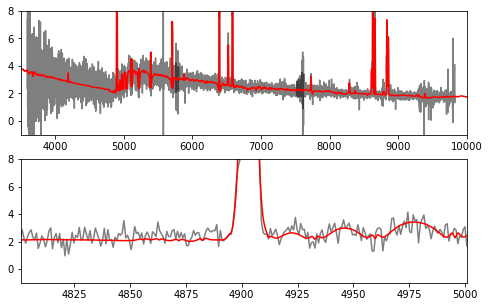

In [13]:
ispec = np.where(spectra.fibermap['TARGETID'] == targetid)[0][0]

figure(figsize=(8,5))
subplot(211)
maxflux = 0.0
for band in spectra.bands:
    plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)
    maxflux = max(maxflux, np.max(spectra.flux[band][ispec]))

plot(twave, tflux, 'r-')
xlim(3500, 10000)
# ylim(-1, 0.9*maxflux)
ylim(-1, 8)

#- zoom in on [OII]
subplot(212)
for band in spectra.bands:
    plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)

plot(twave, tflux, 'r-')
xlim(3727*(1+z)-100, 3727*(1+z)+100)
ylim(-1,8)

That wasn't quite correct because the redrock templates are high resolution
before any instrumental resolution is applied.  Let's update that to include
the spectral resolution.

In [14]:
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
R = Resolution(spectra.resolution_data['b'][ispec])
txflux = R.dot(resample_flux(spectra.wave['b'], twave, tflux))

(4800.8909052488025, 5000.8909052488025)

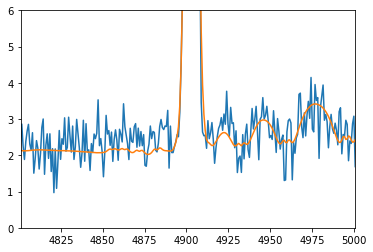

In [15]:
plot(spectra.wave['b'], spectra.flux['b'][ispec])
plot(spectra.wave['b'], txflux)
ylim(0,6)
xlim(3727*(1+z)-100, 3727*(1+z)+100)

## Future work

**TODO**: document redrock rr*.h5 files, e.g. the chi2 vs. redshift and how to get the second, third, etc. best fits

## Code versions

In [ ]:
print('Code versions used for this tutorial:')
desitutorials.print_code_versions()

Code versions used for this tutorial:
python      : 3.9.7
numpy       : 1.21.4
scipy       : 1.7.3
astropy     : 5.0
yaml        : 6.0
matplotlib  : 3.5.1
fitsio      : 1.1.6
healpy      : 1.15.0
desiutil    : 3.2.5
desispec    : 0.51.13
desitarget  : 2.4.0
desimodel   : 0.17.0
redrock     : 0.15.4
speclite    : 0.15
